Electric Boogaloo!

Keras style nn

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

In [33]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
physical_devices

tf.config.experimental.set_memory_growth(physical_devices[0], True)
"""
The above line comes from here: 
https://github.com/tensorflow/tensorflow/blob/6e559b96c8146ce15c7c03f66e515e31a6b0aa00/tensorflow/python/framework/config.py#L443
"""

import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, Input, Reshape, 
                                     Lambda, Dense, Conv2DTranspose)

In [7]:
LATENT_SIZE = 32
BATCH_SIZE  = 128
KL_TOLERANCE = 0.5
LEARNING_RATE = 1e-4

In [8]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    
    # import pdb; pdb.set_trace()
    z_mean, z_log_var = args
    #_batch = z_mean.shape[0]
    #_dim = z_mean.shape[1]
    batch = BATCH_SIZE# if _batch is None else _batch
    dim = LATENT_SIZE #if _dim is None else _dim
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    foo = z_mean + K.exp(0.5 * z_log_var)# * epsilon
    print(foo.shape)
    bar = foo * epsilon
    print(bar.shape)
    return bar


## ENCODER

In [9]:
inputs = Input(shape=(64, 64, 3), name='encoder_input')
h = Conv2D(32, 4, strides=2, activation="relu", name="enc_conv1")(inputs)
h = Conv2D(64, 4, strides=2, activation="relu", name="enc_conv2")(h)
h = Conv2D(128, 4, strides=2, activation="relu", name="enc_conv3")(h)
h = Conv2D(256, 4, strides=2, activation="relu", name="enc_conv4")(h)
h = Reshape([2*2*256])(h)



z_mean = Dense(LATENT_SIZE, name='z_mean')(h)
z_log_var = Dense(LATENT_SIZE, name='z_log_var')(h)
z = Lambda(sampling, output_shape=(LATENT_SIZE,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')


(None, 32)
(128, 32)


In [10]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
enc_conv1 (Conv2D)              (None, 31, 31, 32)   1568        encoder_input[0][0]              
__________________________________________________________________________________________________
enc_conv2 (Conv2D)              (None, 14, 14, 64)   32832       enc_conv1[0][0]                  
__________________________________________________________________________________________________
enc_conv3 (Conv2D)              (None, 6, 6, 128)    131200      enc_conv2[0][0]                  
____________________________________________________________________________________________

## DECODER

In [11]:
latent_inputs = Input(shape=(LATENT_SIZE,), name='decoder_input')
h = Dense(4*256, name="dec_fc")(latent_inputs)
h = Reshape([1, 1, 4*256])(h)
h = Conv2DTranspose(128, 5, strides=2, activation="relu", name="dec_deconv1")(h)
h = Conv2DTranspose(64, 5, strides=2, activation="relu", name="dec_deconv2")(h)
h = Conv2DTranspose(32, 6, strides=2, activation="relu", name="dec_deconv3")(h)
outputs = Conv2DTranspose(3, 6, strides=2, activation='sigmoid', name="dec_deconv4")(h)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 32)]              0         
_________________________________________________________________
dec_fc (Dense)               (None, 1024)              33792     
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 1024)        0         
_________________________________________________________________
dec_deconv1 (Conv2DTranspose (None, 5, 5, 128)         3276928   
_________________________________________________________________
dec_deconv2 (Conv2DTranspose (None, 13, 13, 64)        204864    
_________________________________________________________________
dec_deconv3 (Conv2DTranspose (None, 30, 30, 32)        73760     
_________________________________________________________________
dec_deconv4 (Conv2DTranspose (None, 64, 64, 3)         3459

In [34]:
def sample(decoder, n=128):
    z = tf.random.normal(shape=(n, LATENT_SIZE))
    return decoder.predict(z)

In [20]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='SpatialWorldModel')

(None, 32)
(128, 32)


## Loss stuff

In [21]:
# loss
eps = 1e-6 # avoid taking log of zero

# reconstruction loss
r_loss = tf.reduce_sum(
  tf.square(inputs - outputs),
  axis = [1,2,3]
)
r_loss = tf.reduce_mean(r_loss)

# augmented kl loss per dim (axis may need to change)
kl_loss = - 0.5 * tf.reduce_sum(
  (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
  axis = 1
)
# todo: look this up. why did Ha do it this way?
kl_loss = tf.maximum(kl_loss, KL_TOLERANCE * LATENT_SIZE)
kl_loss = tf.reduce_mean(kl_loss)

loss = r_loss + kl_loss

In [23]:
vae.add_loss(loss)
vae.compile(optimizer='adam')

## Demo fit
Can the model tightly fit just one trace? 

In [3]:
train_images = np.load('./data/traces/play_trace_69.npz')
test = np.load('./data/traces/play_trace_420.npz')

In [27]:
test = test['b']
test = np.true_divide(test, 255, dtype=np.float32)
test = resize(test, output_shape=(1024, 64, 64, 3))

In [4]:
train_images = train_images['b']
train_images = np.true_divide(train_images, 255, dtype=np.float32)
train_images = resize(train_images, output_shape=(1024, 64, 64, 3))


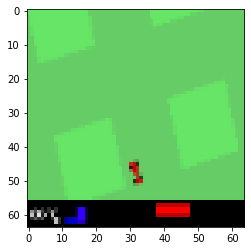

In [5]:
plt.imshow(train_images[242])

In [24]:
history = vae.fit(train_images,
                    epochs=256, 
                    batch_size=BATCH_SIZE)

Train on 1024 samples
Epoch 1/256
(128, 32)
(128, 32)
(128, 32)
(128, 32)
1024/1024 [==============================] - 1s 1ms/sample - loss: 246.3537
Epoch 2/256
1024/1024 [==============================] - 0s 417us/sample - loss: 220.1396
Epoch 3/256
1024/1024 [==============================] - 0s 417us/sample - loss: 203.4724
Epoch 4/256
1024/1024 [==============================] - 0s 417us/sample - loss: 190.5773
Epoch 5/256
1024/1024 [==============================] - 0s 415us/sample - loss: 179.6177
Epoch 6/256
1024/1024 [==============================] - 0s 433us/sample - loss: 168.6472
Epoch 7/256
1024/1024 [==============================] - 0s 414us/sample - loss: 158.3962
Epoch 8/256
1024/1024 [==============================] - 0s 415us/sample - loss: 148.6221
Epoch 9/256
1024/1024 [==============================] - 0s 423us/sample - loss: 140.2349
Epoch 10/256
1024/1024 [==============================] - 0s 421us/sample - loss: 133.8798
Epoch 11/256
1024/1024 [===============

Epoch 91/256
1024/1024 [==============================] - 0s 412us/sample - loss: 73.1273
Epoch 92/256
1024/1024 [==============================] - 0s 413us/sample - loss: 72.6550
Epoch 93/256
1024/1024 [==============================] - 0s 417us/sample - loss: 72.9383
Epoch 94/256
1024/1024 [==============================] - 0s 415us/sample - loss: 72.7488
Epoch 95/256
1024/1024 [==============================] - 0s 417us/sample - loss: 74.5872
Epoch 96/256
1024/1024 [==============================] - 0s 413us/sample - loss: 75.0115
Epoch 97/256
1024/1024 [==============================] - 0s 416us/sample - loss: 76.4437
Epoch 98/256
1024/1024 [==============================] - 0s 417us/sample - loss: 76.0473
Epoch 99/256
1024/1024 [==============================] - 0s 414us/sample - loss: 76.4127
Epoch 100/256
1024/1024 [==============================] - 0s 414us/sample - loss: 73.5775
Epoch 101/256
1024/1024 [==============================] - 0s 415us/sample - loss: 73.7029
Epoch 10

1024/1024 [==============================] - 0s 402us/sample - loss: 64.5678
Epoch 182/256
1024/1024 [==============================] - 0s 422us/sample - loss: 66.2351
Epoch 183/256
1024/1024 [==============================] - 0s 423us/sample - loss: 65.8783
Epoch 184/256
1024/1024 [==============================] - 0s 421us/sample - loss: 64.5214
Epoch 185/256
1024/1024 [==============================] - 0s 422us/sample - loss: 67.1420
Epoch 186/256
1024/1024 [==============================] - 0s 402us/sample - loss: 63.4955
Epoch 187/256
1024/1024 [==============================] - 0s 420us/sample - loss: 64.6677
Epoch 188/256
1024/1024 [==============================] - 0s 401us/sample - loss: 64.9012
Epoch 189/256
1024/1024 [==============================] - 0s 401us/sample - loss: 65.3457
Epoch 190/256
1024/1024 [==============================] - 0s 404us/sample - loss: 66.1579
Epoch 191/256
1024/1024 [==============================] - 0s 398us/sample - loss: 65.0303
Epoch 192/256

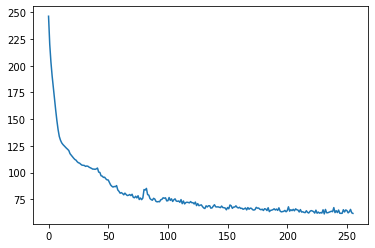

In [25]:
plt.plot(history.history['loss'])

In [26]:
vae.save_weights('./SpatialWorldModel.h5')

In [36]:
s = sample(decoder, 1)

In [38]:
s.shape

(1, 64, 64, 3)

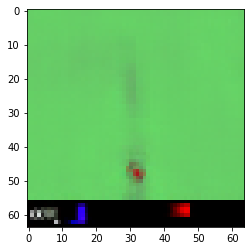

In [39]:
plt.imshow(s.squeeze())

Yep, looks good!

## Real boii fitting

In [73]:
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, 
                                       TensorBoard, Callback)
import datetime
from time import time

In [74]:
class TrainTimeCallback(Callback): 
    def __init__(self): 
        super(TrainTimeCallback, self).__init__()
        
    def on_train_begin(self, logs=None): 
        self._start_time = time()
        
    def on_train_end(self, logs=None):
        self._train_time = time() - self._start_time
        
    @property
    def train_time(self):
        s = self._train_time
        hours, remainder = divmod(s, 3600)
        minutes, seconds = divmod(remainder, 60)
        
        return f'{hours:02.0f}:{minutes:02.0f}:{seconds:02.0f}'
    
    def print_train_time(self):
        print(f'Train time for model: {self.train_time}')

In [75]:
!mkdir "./logs/"
!mkdir "./logs/fit"
!rm "./logs/fit/*"

mkdir: cannot create directory ‘./logs/’: File exists
mkdir: cannot create directory ‘./logs/fit’: File exists
rm: cannot remove './logs/fit/*': No such file or directory


In [76]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [77]:
monitor = 'loss' # change this
callbacks = [
    TrainTimeCallback(),
    ModelCheckpoint('./best_VAE.h5', save_best_only=True, 
                    monitor=monitor),
    EarlyStopping(monitor, patience=10,
                  mode='min',
                  restore_best_weights=True),
    TensorBoard(log_dir=log_dir, histogram_freq=1)
]

In [78]:
history = vae.fit(train_images,
                    epochs=256, 
                    batch_size=BATCH_SIZE,
                 callbacks=callbacks)
callbacks[0].print_train_time()

Train on 1024 samples
Epoch 1/256
1024/1024 [==============================] - 1s 936us/sample - loss: 54.9099
Epoch 2/256
1024/1024 [==============================] - 2s 2ms/sample - loss: 53.4788
Epoch 3/256
1024/1024 [==============================] - 1s 735us/sample - loss: 57.2538
Epoch 4/256
1024/1024 [==============================] - 1s 744us/sample - loss: 54.2339
Epoch 5/256
1024/1024 [==============================] - 1s 737us/sample - loss: 56.5657
Epoch 6/256
1024/1024 [==============================] - 1s 739us/sample - loss: 54.6146
Epoch 7/256
1024/1024 [==============================] - 1s 740us/sample - loss: 55.5279
Epoch 8/256
1024/1024 [==============================] - 1s 743us/sample - loss: 53.9493
Epoch 9/256
1024/1024 [==============================] - 1s 747us/sample - loss: 55.0406
Epoch 10/256
1024/1024 [==============================] - 1s 736us/sample - loss: 53.9214
Epoch 11/256
1024/1024 [==============================] - 1s 742us/sample - loss: 54.7681

In [79]:
ls

AWM_environment.yml*     data/                    SpatialWorldModel/
best_VAE.h5              demo.ipynb*              SpatialWorldModel.h5
collecting_state.ipynb*  listenToYourHeart.ipynb  VAE_2.ipynb
collect.py*              logs/                    vae.ipynb
cvae.ipynb*              ModelsZoo.ipynb*
